In [1]:
import os
import sys
import cv2
import shutil
import math

from collections import defaultdict
from glob import glob
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np

%load_ext autoreload
%autoreload 2

from visualization.vis_utils import *


In [5]:
import torch
torch.__version__, torch.cuda.is_available()

('2.0.1', False)

# Visualize burst shots for each location in a single 

In [ ]:
def visualize_bursts(burst_dir, num_rows=10, num_cols=20, figwidth=20):
    
    bursts = sorted(os.listdir(burst_dir), key=lambda x: int(x[5:]))
    
    num_rows = min(num_rows, len(bursts))
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(figwidth, figwidth*num_rows/num_cols))
    if num_rows==1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_rows):
        
        shots = sorted(glob(f"{burst_dir}/{bursts[i]}/*.tiff"))
        
        # Calculate the step size
        col_step = max(1, len(shots)//num_cols)
        
        col_files = []
        for j,file in enumerate(shots[::col_step][:num_cols]): # Slice the shots to fit the number of columns
            img = plt.imread(file)
            axes[i][j].imshow(img[100:400, 200:500])
            col_files.append(os.path.basename(file))

        # set y-label to each row
        axes[i][0].set_ylabel(f"Burst{i+1}", fontsize=8)

    # set x-label to each col
    for j, cfile in enumerate(col_files):
        axes[-1][j].set_xlabel(cfile.split(".")[0], fontsize=8)

    # Hide X and Y axes tick marks
    for ax in axes.flatten():
        ax.set_xticks([])
        ax.set_yticks([])

    fig.suptitle(f"{'_'.join(burst_dir.split('/')[3:])}")
    plt.tight_layout()
    
    return fig, axes
    # plt.show()

    
root_dir = "../data/FS_LIDT_SEPT22/Sample_NF"

for dir_name in sorted(os.listdir(root_dir)):
    
    print(f"Plotting {dir_name=}")
    
    data_dir = f"{root_dir}/{dir_name}"
    
    plot_dir = f"../data/visualization/{dir_name}"
    os.makedirs(plot_dir, exist_ok=True)
    
    
    for row_id in tqdm(sorted(os.listdir(data_dir))):
        
        if not os.path.isdir(f"{data_dir}/{row_id}"):
            continue
            
        for col_id in sorted(os.listdir(f"{data_dir}/{row_id}")):

            fig, axes = visualize_bursts(f"{data_dir}/{row_id}/{col_id}")

            fig.savefig(f"{plot_dir}/{row_id}_{col_id}.png", dpi=500)
            plt.close('all')


# Normalize image in range 0-255 and convert tiff -> png

In [ ]:
src_data_dir = "../data/FS_LIDT_SEPT22/Sample_NF"
dest_data_dir = "../data/near_field/images"

for dir_name in sorted(os.listdir(src_data_dir)):
    
    print("Converting to PNG images", dir_name)
    shutil.rmtree(f"{dest_data_dir}/{dir_name}", ignore_errors=True)
    
    for row in sorted(os.listdir(f"{root_dir}/{dir_name}")):
        for col in sorted(os.listdir(f"{root_dir}/{dir_name}/{row}")):
            
            dest_img_dir = f"{dest_data_dir}/{dir_name}/{int(row[3]):02d}_{int(col[3]):02d}"
            os.makedirs(dest_img_dir, exist_ok=True)
            
            for burst in sorted(os.listdir(f"{root_dir}/{dir_name}/{row}/{col}")):
                for shot in sorted(os.listdir(f"{root_dir}/{dir_name}/{row}/{col}/{burst}")):
                    
                    img = cv2.imread(f"{root_dir}/{dir_name}/{row}/{col}/{burst}/{shot}", cv2.IMREAD_UNCHANGED)
                    img = (img-img.min())/(img.max()-img.min()) * 255
                    cv2.imwrite(f"{dest_img_dir}/burst{int(burst[5:]):02d}_shot{int(shot.split('.')[0][4:]):03d}.png", img)


# Create video from images

In [ ]:
src_data_dir = "../data/near_field/images"
dest_data_dir = "../data/videos"

shutil.rmtree(f"{dest_data_dir}", ignore_errors=True)
os.makedirs(dest_data_dir, exist_ok=True)

for dir_name in sorted(os.listdir(src_data_dir)):
    print(f"Creating videos of {dir_name}")
    
    shutil.rmtree(f"{dest_data_dir}/{dir_name}", ignore_errors=True)
    
    for loc in sorted(os.listdir(f"{src_data_dir}/{dir_name}")):
        
        if len(loc.split('.'))>0:
            continue
            
        create_video_from_images(f"{src_data_dir}/{dir_name}/{loc}", 
                                 f"{dest_data_dir}/{dir_name}_{loc}.avi", 
                                 fps=10, 
                                 display_text=True)
        

# Plot image/patch intensity

In [ ]:

def agg_func(x, mode):
    if mode=='mean':
        return x.mean() if len(x)>0 else 0
    elif mode=='sum':
        return x.sum()
    else:
        raise Exception (f"Mode to compute intensity not valid!")
    
def img_intensity(img, mode='sum'):
    # img = Image.open(file)
    # img = np.asarray(img, dtype="int32")/255
    return agg_func(img, mode)

def img_patch_intensity(img, patch_size=16, mode='sum'):
    # img = Image.open(file)
    # img = np.array(img, dtype='int32')/255
    
    img_height, img_width = img.shape
    num_rows, num_cols = math.ceil(img_height/patch_size), math.ceil(img_width/patch_size)
    
    patch_ints = []
    for y in range(0, img_height, patch_size):
        for x in range(0, img_width, patch_size):
            img_patch = img[y:y+patch_size, x:x+patch_size]
            patch_ints.append(agg_func(img_patch, mode))

    return np.array(patch_ints).reshape(num_rows, num_cols) 


## Visualize a patch 

In [ ]:

frame_num = 611
patch_size = 25
px, py = (12, 12) # patch index/location

img_dir = "../data/near_field/images/Grating_A6/01_02"

img_files = sorted(glob(f"{img_dir}/*"))
                   
img = plt.imread(img_files[frame_num])

fig, ax = create_figure(figsize=(8,5), title=f"Frame{frame_num}")
ax.imshow(img)

# add grid
ax = add_grid_to_axes(ax, grid_size=patch_size, labelsize=4)

# highlight the patch
rect = mpl.patches.Rectangle((px*patch_size, py*patch_size), 
                             patch_size, patch_size, linewidth=1, 
                             edgecolor='r', facecolor='none')

ax.add_patch(rect)


# Visualize specific patch over time (moving from left to right and top to bottom)

In [ ]:
x, y = int(patch_idx[0]*patch_size), int(patch_idx[1]*patch_size)

img_patches = []
for file in img_files:
    img = plt.imread(file)
    img_patches.append(img[y:y+patch_size, x:x+patch_size])

# visualzie sampled patches across frames (to save time)
sample_step = 2
sampled_img_patches= img_patches[::sample_step]

nrows = int(np.sqrt(len(sampled_img_patches)))
ncols = math.ceil(len(sampled_img_patches)/nrows)

fig, axes = create_figure(nrows, ncols, figwidth=12, axis_off=True)
axes = np.ravel(axes)

for i, patch in enumerate(sampled_img_patches):
    axes[i].imshow(patch, vmin=0, vmax=1) 
    axes[i].set_title(str(i*sample_step), color='r', fontsize=5, va='top')
    

# Plot time-series patch intensity

In [ ]:
%load_ext autoreload
%autoreload 2

from visualization.vis_utils import *

colors = np.random.rand(1000, 3)
patch_ints = [patch.sum() for patch in img_patches]

fig, ax = create_figure(figsize=(8,5))

ax.plot(patch_ints, color=colors[0], label='Intensity')
# ax.plot(patch_ints[1:]-patch_ints[:-1], color=colors[0], label='IntensityDiff')

patch_gradients = [img_gradient(patch).sum() for patch in img_patches]
ax.plot(patch_gradients, color=colors[0], label='Gradients')
ax = add_grid_to_axes(ax, grid_size=(5, 20), labelsize=4, minor_ticks=True)


In [ ]:
fig, ax = create_figure(figsize=(8,5))
img_gradients = [img_gradient(plt.imread(file)) for file in img_files]
ax.plot(img_gradients)

## Generate class labels 

In [ ]:
data_dir = '../data/near_field'
dset = 'Grating_A6'
loc = '01_02'

img_files = sorted(glob(f"{data_dir}/images/{dset}/{loc}/*"))
print(f"{len(img_files)=}")

os.makedirs(f"{data_dir}/labels/{dset}", exist_ok=True)
with open(f"{data_dir}/labels/{dset}/{loc}.txt", 'w+') as f:
    for idx in range(len(img_files)):
        img_file = '/'.join(img_files[idx].split('/')[-3:])
        label = 1 if idx>610 else 0
        f.write(img_file + ',' + str(label) + '\n')

    print(f"{idx} labels ")

In [ ]:
from utils.misc import load_file

val_split = 0.3

train_labels = []
val_labels = []

for file in sorted(os.listdir(f"{data_dir}/labels/{dset}")):
    
    # # Separate the labels into classes
    cls_dict = defaultdict(list)
    for label in load_file(f"{data_dir}/labels/{dset}/{file}"):
        _, c = label.split(',')
        cls_dict[c].append(label)
    
    # Split each class labels into training and validation sets                           
    for c, class_labels in cls_dict.items():
        print(f"{c=}, {len(class_labels)} images ")
        split_indx = int(len(class_labels)*(1-val_split))
        train_labels.extend(class_labels[:split_indx])
        val_labels.extend(class_labels[split_indx:])

print(f"train labels: {len(train_labels)}")
print(f"val labels: {len(val_labels)}")

In [ ]:
611+289

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


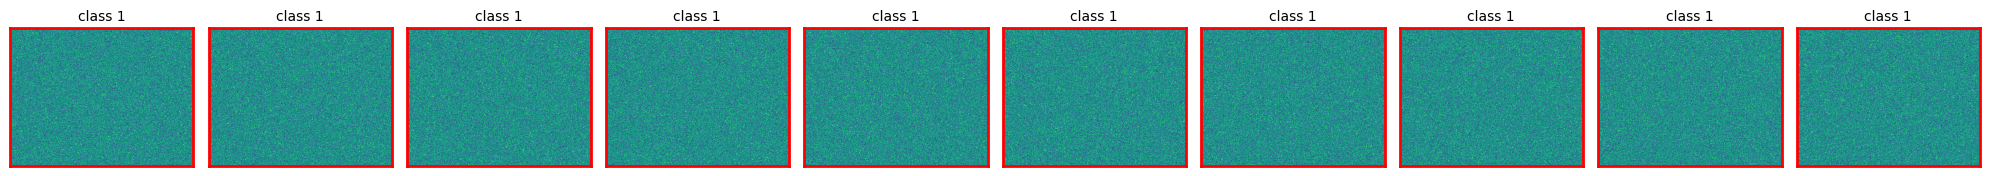

In [29]:
from visualization.vis_utils import create_figure
%load_ext autoreload
%autoreload 2

import torch

n_images = 10
images = np.random.rand(n_images, 492, 656)
B, H, W = images.shape

num_rows = 1
num_cols = min(n_images, B)
subplot_width = 2
fig, axes = create_figure(num_rows, num_cols, subplot_size=(subplot_width, W/H*subplot_width), axis_off=True)
for i in range(num_cols):
    axes[0, i].imshow(images[i])
    axes[0, i].set_title('class 1', fontsize=10)
    for spine in axes[0, i].spines.values():
        spine.set_edgecolor('red')
        spine.set_linewidth(2) 

In [9]:
fig.get_size_inches()

array([5.  , 0.75])